### LOADING LIBRARIES

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import cv2, glob, os
import time
from pathlib import Path
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from generator import *
from utils import *

In [5]:
print(tf.__version__)

1.13.1


In [3]:
SEED = 100
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

***Uncomment below cell to download data***

In [4]:
# !wget http://imagenet.stanford.edu/internal/car196/cars_annos.mat
# !wget http://imagenet.stanford.edu/internal/car196/car_ims.tgz
##!sudo apt-get install tar
# !tar xvzf car_ims.tgz

### LOADING DATA

In [5]:
!python generate_csv.py

/media/danish/Data/anaconda/envs/tf/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
img_path = Path('./')

In [7]:
data = scipy.io.loadmat('./cars_annos.mat')
classes = {i:data['class_names'][0][i][0] for i in range(data['class_names'].shape[1])}

In [8]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [9]:
train_data.target -=1
test_data.target -=1

In [10]:
train_data.head()

,filename,target
0,car_ims/006510.jpg,79
1,car_ims/009098.jpg,110
2,car_ims/013462.jpg,163
3,car_ims/010743.jpg,129
4,car_ims/012100.jpg,146


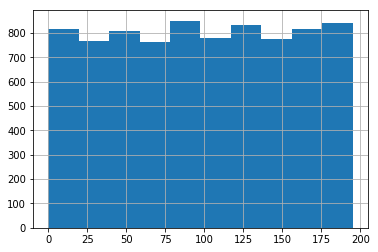

In [11]:
train_data.target.hist()

In [13]:
name_label={v:k for k,v in classes.items()}

In [14]:
def to_ohe(label,num_classes=7):
    return np.array(K.utils.to_categorical(label,num_classes=num_classes))

(184, 274, 3)


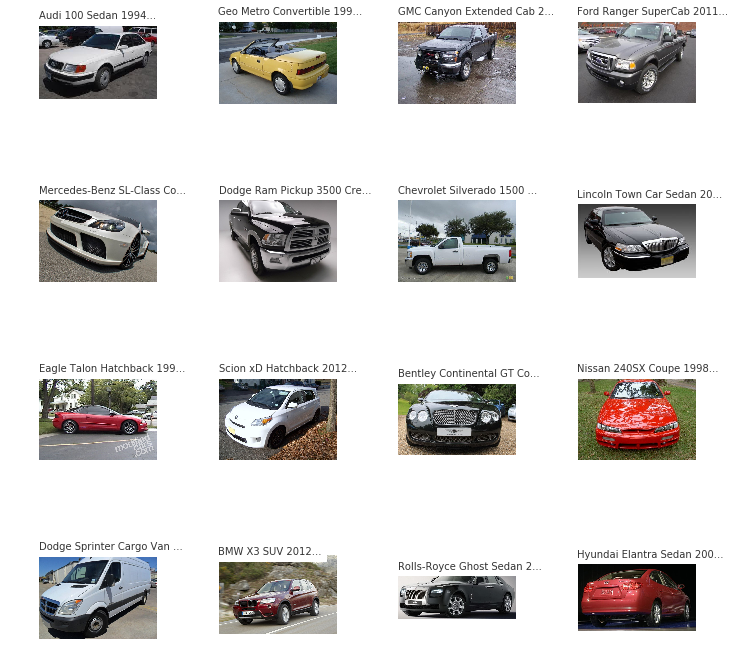

In [15]:
plot_batch_img(img_path,train_data,classes,batch=30)

In [16]:
## Splitting data into train and validation set
train_data,valid_data = train_test_split(train_data,test_size=0.1,random_state=SEED)
train_data.shape,valid_data.shape

((7236, 2), (805, 2))

### GENERATOR

In [ ]:
from albumentations import (HorizontalFlip, IAAPerspective, ShiftScaleRotate,
                            CLAHE, RandomRotate90, Transpose, ShiftScaleRotate,
                            Blur, OpticalDistortion, GridDistortion,
                            HueSaturationValue, IAAAdditiveGaussianNoise,
                            GaussNoise, MotionBlur, MedianBlur,
                            IAAPiecewiseAffine, IAASharpen, IAAEmboss,
                            RandomBrightnessContrast, Flip, OneOf, Compose)


def randomAugment(p=0.7):
    return Compose([
        HorizontalFlip(p=0.5),
        Rotate(limit=(-30,30), p=0.5),
        HueSaturationValue(p=0.2),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.3),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
    ], p=p)

In [17]:
def load_img(path):
    '''Load, Resize and Convert image from BGR format to RGB format'''
    img = cv2.imread(path)
    img = cv2.resize(img, (input_size, input_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [18]:
#Input size of the model
input_size=224

In [30]:
class DataGenerator(Sequence):
    '''Generate batch of images and target'''
    def __init__(self,df, bs,is_valid=False):
        '''Initialize the Generator class
        Parameters :
            df : DataFrame, containing names and target value of images
            bs : int , batch size
            is_valid : Bool, Flag for applying data augmentation 
        '''
    def __init__(self, df, bs, is_valid=False):
        self.df = df
        self.bs = bs
        self.is_valid = is_valid 
        self.augmentation = randomAugment(p=0.7)
        
    def __len__(self) :
        '''Return the length of the data'''
        return np.ceil(self.df.shape[0] / self.bs).astype(int)

    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        if self.is_valid == False:
            self.df = shuffle(self.df, random_state=SEED)
            self.df.reset_index(inplace=True, drop=True)

    def set_bs(self,new_bs) :
        '''Change the batch size by by passing new batch size'''
        self.bs=new_bs
    
    def __getitem__(self, idx):
        '''Generate batch of images and target'''
        x_batch, y_batch = [], []
        start = idx * self.bs
        end = (idx + 1) * self.bs
        ids_train_batch = self.df.filename[start:end].values
        labels = self.df.target[start:end].values
        for i, ids in enumerate(ids_train_batch):
            img = load_img(str(img_path / ids))
            target = to_ohe(labels[i],196)
            ## Augmentation
            if not self.is_valid:
                img = self.augmentation(image=(img).astype(np.uint8))['image']
            x_batch.append(img)
            y_batch.append(target)
        x_batch = np.array(x_batch, np.float32) / 255.
        y_batch = np.array(y_batch, np.float32)

        return x_batch, y_batch
        

In [48]:
bs = 16

In [49]:
train_generator = DataGenerator(train_data,bs,False)
valid_generator = DataGenerator(valid_data,bs,True)

In [50]:
l = valid_generator.__getitem__(5)
l[0].shape,l[1].shape

((16, 224, 224, 3), (16, 196))

### METRICS

In [1]:
def precision(y_true, y_pred,thresh=0.2):
    '''Computes the precision between predictions and ground truth'''
#     y_pred = float(y_pred>thresh)
#     y_true = float(y_true)
    true_positive = tf.reduce_sum(y_pred*y_true,axis=1)
    precision = true_positive / (tf.reduce_sum(y_pred, axis = 1)+eps)
    return tf.reduce_mean(precision)

def recall(y_true, y_pred,thresh=0.2):
    '''Computes the recall between predictions and ground truth'''
#     y_pred = float(y_pred>thresh)
#     y_true = float(y_true)
    true_positive = tf.reduce_sum(y_pred*y_true,axis=1)
    recall = true_positive /  (tf.reduce_sum(y_true, axis = 1)+eps)
    return tf.reduce_mean(recall)

In [2]:
def fbeta(y_true, y_pred, thresh=0.2, beta=2, eps=1e-9):
    '''Computes the fbeta between predictions and ground truth'''
    beta2 = beta ** 2
#     y_pred = float(y_pred>thresh)
#     y_true = float(y_true)
    true_positive = tf.reduce_sum(y_pred*y_true,axis=1)
    precision = true_positive / (tf.reduce_sum(y_pred, axis = 1)+eps)
    recall = true_positive /  (tf.reduce_sum(y_true, axis = 1)+eps)
    result = ((precision*recall)/(precision*beta2+recall+eps))*(1+beta2)
    return tf.reduce_mean(result)


from sklearn.metrics import fbeta_score
from keras import backend as K

##https://www.kaggle.com/arsenyinfo/f-beta-score-for-keras
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return tf.reduce_mean(result)

y_true, y_pred = np.round(np.random.rand(100)), np.random.rand(100)

fbeta_keras = fbeta(K.variable(y_true), K.variable(y_pred)).eval(session=K.get_session())
fbeta_sklearn = fbeta_score(y_true, np.round(y_pred), beta=2)

print('Scores are {:.3f} (sklearn) and {:.3f} (keras)'.format(fbeta_sklearn, fbeta_keras))


### MODEL

In [51]:
input_size=224
numclass=196

In [52]:
def get_model():
    #Pretrained Xception network without head
    pretrained_model = K.applications.Xception(
        weights="imagenet",
        input_tensor=k.layers.Input(shape=(input_size, input_size, 3),
                                    name='feature'),
        include_top=False)
    #Freezing the body of the network
    for layer in pretrained_model.layers:
        layer.trainable = False
    #Head of the model
    x = pretrained_model.output
    x = k.layers.GlobalAveragePooling2D()(x)
    x = k.layers.Dense(512,name='head_dense',kernel_initializer=k.initializers.he_normal(10))(x)
    x = K.layers.BatchNormalization()(x)
    x = K.layers.ReLU()(x)
    output = k.layers.Dense(numclass,
                            name='predictions',
                            activation='softmax',
                            kernel_initializer=k.initializers.he_normal(10))(x)
    model = k.Model(inputs=pretrained_model.input,
                    outputs=output,
                    name='Classification_Network')

    return model

In [53]:
model = get_model()
model.summary(110)

______________________________________________________________________________________________________________
Layer (type)                        Output Shape            Param #      Connected to                         
feature (InputLayer)                (None, 224, 224, 3)     0                                                 
______________________________________________________________________________________________________________
block1_conv1 (Conv2D)               (None, 111, 111, 32)    864          feature[0][0]                        
______________________________________________________________________________________________________________
block1_conv1_bn (BatchNormalization (None, 111, 111, 32)    128          block1_conv1[0][0]                   
______________________________________________________________________________________________________________
block1_conv1_act (Activation)       (None, 111, 111, 32)    0            block1_conv1_bn[0][0]                
_

### TRAINING

In [54]:
learning_rate=0.005
adam=k.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['categorical_accuracy',precision,recall,fbeta])

In [55]:
def fit(epoch=2):
    model.fit_generator(
        generator=train_generator,
        steps_per_epoch=int(np.ceil(train_data.shape[0]) / (bs)),
        epochs=epoch,verbose=1,
        validation_data=valid_generator,
        shuffle=True,workers=4,
        validation_steps=int(np.ceil(valid_data.shape[0]) / (bs)))

In [56]:
fit(3)

Epoch 1/3
453/453 [==============================] - 61s 134ms/step - loss: 5.0432 - acc: 0.1016 - val_loss: 6.8431 - val_acc: 0.0857
Epoch 2/3
453/453 [==============================] - 97s 215ms/step - loss: 2.7988 - acc: 0.3691 - val_loss: 7.7342 - val_acc: 0.0596
Epoch 3/3
453/453 [==============================] - 111s 245ms/step - loss: 1.9847 - acc: 0.5267 - val_loss: 7.5142 - val_acc: 0.0969


In [57]:
for layer in model.layers:
    layer.trainable = True
lr = 1e-3
adam=k.optimizers.Adam(lr=lr)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [58]:
fit(10)

Epoch 1/10
296/453 [==================>...........] - ETA: 2:29 - loss: 5.5237 - acc: 0.0072

KeyboardInterrupt: 

In [ ]:
k.backend.set_value(adam.lr,lr/3)
fit(10)